### Find Path with Minimum Cost

This project explores two approaches to the **minimum-cost path problem** in a 2D grid:  

- **Problem statement**:  
  Given a cost matrix `C ∈ ℝ^{m×n}`, find a path from the top-left `(0,0)` to the bottom-right `(m-1,n-1)` with the smallest total cost.  
  At each step, you may move **down** `(i+1,j)` or **right** `(i,j+1)`.  

- **Naïve enumeration (custom brute-force solver)**:  
  I manually enumerated all paths up to length 3 using step encodings `{-1,1}` for down/right moves.  
  The algorithm stitched together optimal subpaths block by block.  
  This brute-force approach works for small grids but scales poorly.

- **Dynamic programming (DP)**:  
  Implemented the textbook recurrence:
  $$
  dp[i][j] = \min(dp[i-1][j], \; dp[i][j-1]) + C[i][j]
  $$
  with $dp[0][0] = C[0][0]$.  
  to obtain the optimal path.  
  This yields an efficient $O(mn)$ solution.

- **Comparison**:  
  - Enumeration = efficiency blow-up, only feasible for toy cases.  
  - DP = polynomial time, scalable to large grids.

In [95]:
import numpy as np
from copy import deepcopy

In [96]:
def add(tuple1, tuple2):
    return tuple([tuple1[i]+tuple2[i] for i in range(len(tuple1))])

def find_path(steps, start, pos_cost_dict, bound):
    my_dict = {-1:(1,0), 1:(0,1)}
    if steps == 1:
        paths, costs = [[-1],[1]], ([],[])
    elif steps == 2:
        paths, costs = [[-1,-1], [-1,1], [1,-1], [1,1]], ([],[],[],[])
    elif steps == 3:
        paths = [[-1,-1,-1],
                 [-1,-1,1],[-1,1,-1],[1,-1,-1],
                 [-1,1,1],[1,-1,1],[1,1,-1],
                 [1,1,1]]
        costs = ([],[],[],[],[],[],[],[])

    ends, paths_copy = [[]]*len(costs), deepcopy(paths)
    for i, path in enumerate(paths):
        current_pos = start
        for jump in path:
            current_pos = add(current_pos, my_dict[jump])
            try:
                costs[i].append(pos_cost_dict[current_pos])
            except KeyError:
                break
        ends[i] = current_pos
    summed_costs = [sum(cost) if len(cost) == steps else bound for cost in costs]
    optimal_path, end = paths[summed_costs.index(min(summed_costs))], ends[summed_costs.index(min(summed_costs))]

    return costs, optimal_path, end


def for_small_grid(grid, start_cell, steps):
    if steps >= 4:
        print('Grid size too large! Function passed!')
    else:
        start, pos_cost_dict = start_cell.position, grid.pos_cost_dict
        costs, optimal_path, end = find_path(steps, start, pos_cost_dict, grid.bound)
        end_cell = grid.cells[end[0]][end[1]]
        return costs, optimal_path, end_cell


class Cell:
    def __init__(self, cost, position):
        self.cost = cost
        self.position = position

class Grid:
    def __init__(self, cells): # cells = 2D Numpy array
        self.cells = cells
        self.size = cells.shape[0], cells.shape[1]
        pos_cost_dict = {}
        for i in range(self.size[0]):
            for j in range(self.size[1]):
                pos_cost_dict[(i,j)] = cells[i][j].cost
        self.pos_cost_dict = pos_cost_dict

        cost_array_all = np.array([[self.cells[i][j].cost for i in range(self.size[0])]
                                    for j in range(self.size[1])], dtype=int)
        self.bound = np.sum(cost_array_all)

    def solve_brute_force(self):
        total_steps = self.size[0] + self.size[1] - 2
        last_step = total_steps % 3
        num_iters = int(total_steps/3)
        # print('num_iters = ', num_iters)
        end_cell, solution_path = self.cells[0][0], []
        for i in range(num_iters):
            costs, optimal_path, end_cell = for_small_grid(self, end_cell, 3)
            solution_path.append(optimal_path)
        if last_step != 0:
            costs, optimal_path, end_cell = for_small_grid(self, end_cell, last_step)
            solution_path.append(optimal_path)

        return solution_path, end_cell

    def get_min_cost_table(self):
        cells, size, bound = self.cells, self.size, self.bound
        steps, table = size[0] + size[1] - 2, np.empty(size)
        table[0][0] = cells[0][0].cost
        for step in range(1, steps+1):
            diagonal = [(step-i, j) for i,j in zip(range(step+1), range(step+1))]
            diagonal = list(filter(lambda x: x[0]<size[0] and x[1]<size[1], diagonal))
            for pos in diagonal:
                if pos[0]-1 >= 0:
                   cost1 = table[pos[0]-1][pos[1]]
                else:
                   cost1 = bound
                if pos[1]-1 >= 0:
                    cost2 = table[pos[0]][pos[1]-1]
                else:
                    cost2 = bound
                table[pos[0]][pos[1]] = min(cost1, cost2) + cells[pos[0]][pos[1]].cost
        return table


    def solve_dynamic_programming(self):
        size, table = self.size, self.get_min_cost_table()
        steps = size[0] + size[1] - 2
        current = (size[0]-1, size[1]-1)
        path = [current]
        for step in range(steps):
            if current[0]-1 >= 0 and current[1]-1 >= 0:
                if table[current[0]-1][current[1]] <= table[current[0]][current[1]-1]:
                    current = (current[0]-1, current[1])
                else:
                    current = (current[0], current[1]-1)
            elif current[0]-1 >= 0:
                current = (current[0]-1, current[1])
            else:
                current = (current[0], current[1]-1)
            path.append(current)
        path.reverse()
        return path

In [97]:
grid = Grid(np.array([[Cell(1,(0,0)), Cell(3,(0,1)), Cell(10,(0,2)), Cell(4,(0,3))],
                      [Cell(9,(1,0)), Cell(6,(1,1)), Cell(7,(1,2)), Cell(8,(1,3))],
                      [Cell(4,(2,0)), Cell(1,(2,1)), Cell(6,(2,2)), Cell(12,(2,3))],
                      [Cell(13,(3,0)), Cell(4,(3,1)), Cell(15,(3,2)), Cell(16,(3,3))]]))

solution_path, end_cell = grid.solve_brute_force()

print(f"Brute-force solution path: {solution_path}")
print(f"End cell: {end_cell.position}\n")
print(f"Dynamic Programming solution:\n{grid.solve_dynamic_programming()}")

Brute-force solution path: [[1, -1, -1], [1, 1, -1]]
End cell: (3, 3)

Dynamic Programming solution:
[(0, 0), (0, 1), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3)]


### Interval Scheduling – All Optimal Solutions

This project tackles the **Interval Scheduling Problem**, a classical CS optimization task:

> Given a set of intervals (courses) with start and end times, select the maximum number of mutually non-overlapping intervals.

#### Classical Greedy Algorithm
- Sort intervals by **earliest finishing time**.  
- Sweep once, always choosing the next interval that starts after the last chosen one ends.  
- Guarantees **one optimal solution**, but not all of them.

#### My Implementation
Instead of returning just one optimal chain, I implemented an enumeration approach:

1. **Represent courses** as objects with `(start, end)` times.  
2. **Sort** courses by their finishing times (same as greedy).  
3. For **each course** as a starting point, build the longest compatible chain by repeatedly selecting the next non-overlapping course.  
4. Collect all chains, then extract the longest ones.  

This way, if multiple optimal schedules exist, they all appear in the output.

In [ ]:
import pandas as pd

In [ ]:
class Course:
    def __init__(self, number, start, end):
        self.number = number
        self.start = start
        self.end = end

In [ ]:
input_problem = [(1,4),(3,5),(0,6),(5,7),(3,8),(5,9),(6,10),(8,11),(8,12),(2,13)]

courses = [Course(i+1, x[0], x[1]) for i, x in enumerate(input_problem)]

courses = sorted(courses, key=lambda x: x.end)
df = pd.DataFrame(index=[course.number for course in courses],
                  columns=['start', 'end'])
df['start'] = [course.start for course in courses]
df['end'] = [course.end for course in courses]
df

,start,end
1,1,4
2,3,5
3,0,6
4,5,7
5,3,8
6,5,9
7,6,10
8,8,11
9,8,12
10,2,13


In [ ]:
course_nums, total = df.index, len(df)
can_be_scheduled = [[int(course_num)] for course_num in course_nums]
for i, num in enumerate(course_nums):
    to_compare, search_point = num, i+1

    while True:
        for j in range(search_point, total):
            if df.at[course_nums[j], 'start'] >= df.at[to_compare, 'end']:
                to_compare, search_point = course_nums[j], j+1
                can_be_scheduled[i].append(int(to_compare))
                break
        if j == total - 1:
            break

display(can_be_scheduled)
check_len = [len(x) for x in can_be_scheduled]
max_check_len = max(check_len)
while max_check_len in check_len:
    solution = can_be_scheduled[check_len.index(max_check_len)]
    print('solution ', solution)
    can_be_scheduled.remove(solution)
    check_len.remove(max_check_len)

[[1, 4, 8], [2, 4, 8], [3, 7], [4, 8], [5, 8], [6], [7], [8], [9], [10]]

solution  [1, 4, 8]
solution  [2, 4, 8]


### Fractals—Mandelbrot Set

Implemented the Mandelbrot recurrence  

$$
z_{k+1} = z_k^2 + c, \quad z_0 = 0
$$  

to check divergence on a grid of complex numbers. Iteration counts are visualized with `matplotlib` to render the fractal.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from seaborn import heatmap

In [ ]:
# z = z1 + z2i
# z^2 = (z1^2 - z2^2) + 2z1z2i

def mandelbrot(c1, c2, z1=0,z2=0):
    return (z1**2-z2**2+c1, 2*z1*z2+c2)

# diverge: ∀ M >= 0, ∃ n ∈ N s.t. |z_k| > M ∀ k >= n
# doesn't diverge: ∃ M s.t. |z_k| <= M ∀ k ∈ N

def get_num_iters(c1, c2, bound, max_iter, z1=0, z2=0):
    i = 1
    while i <= max_iter:
        z1, z2 = mandelbrot(c1,c2,z1,z2)
        if z1**2+z2**2 >= bound:
            return i
        i += 1
    return i

def get_iter_grid(lower, upper, interval, bound, max_iter, z1=0, z2=0):
    num_points = int((upper-lower)/interval)
    x, y = np.linspace(lower, upper, num_points), np.linspace(lower, upper, num_points)
    iter_grid = np.empty((num_points, num_points))
    for i, c1 in enumerate(x):
        for j, c2 in enumerate(y):
            iter_grid[i][j] = get_num_iters(c1, c2, bound, max_iter)
    return iter_grid

In [ ]:
iter_grid = get_iter_grid(-1.5, 1.2, 0.01, 1000, 1000)

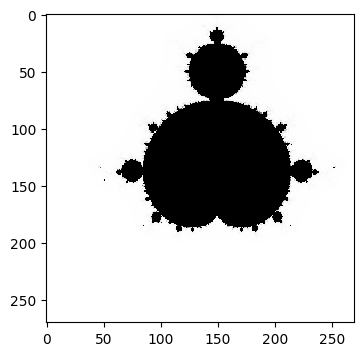

In [ ]:
plt.figure(figsize = (5,4))
plt.imshow(iter_grid, cmap='binary', interpolation ='nearest', origin ='upper')
plt.show()

### Elliptic Curves over Finite Fields (Toy Implementation from Scratch)

I explord the algebraic structure of elliptic curves over a finite field **$F_p$**:

- Implements the short Weierstrass form:  
  $$
  y^2 \equiv x^3 + ax + b \pmod p
  $$
- Checks for **singularity** using the discriminant  
  $\Delta = -16(4a^3 + 27b^2) \pmod p$.
- Enumerates all points `(x, y)` on the curve modulo *p*, plus the point at infinity.
- Implements **point addition and doubling** (group law) using modular inverses in $F_p$.
- Visualizes points both:
  - Discrete points mod _p_ (scatter plot).  
  - Continuous real curve for intuition $y^2 = x^3 + ax + b$.

⚠️ **Note:** This is an _exploratory demo_, not a cryptographically secure library.  
Goal: practice with **modular arithmetic**, **algebraic geometry**, and **group operations** in code form.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from collections import namedtuple
import hashlib
import struct

In [ ]:
class Elliptic_Curve:
    def __init__(self, p, a, b):
        self.p = p
        self.a = a % p
        self.b = b % p
        #self.equation = ??

    def singular(self):
        Delta = (-16*(4*(self.a)**3 + 27*(self.b)**2)) % self.p
        self.Delta = Delta
        if Delta != 0:
            return False
        else:
            return True

    def get_points(self):
        n, p, a, b = 0, self.p, self.a, self.b
        for x in range(p):
            value = (x**3 + a*x + b) % p
            y_count = 0
            for y in range(p):
                if y**2 % p == value:
                    yield (x,y)
                    n += 1
                    y_count += 1
                    if y_count == 2:
                        break
        self.n = n + 1

    def add(self, P, Q): # P, Q are instances of class Point
        p, a, b, x1, x2, y1, y2 = self.p, self.a, self.b, P.x, Q.x, P.y, Q.y
        if x1 is None and x2 is None:
            return Point(self, None, None)
        elif x1 is None and x2 is not None:
            return Point(self, x2, y2)
        elif x1 is not None and x2 is None:
            return Point(self, x1, x2)
        else:
            x2_x1, y2_y1 = F_p(p, (x2-x1)%p), F_p(p, (y2-y1)%p)
            if x2_x1.value != 0 and y2_y1.value != 0:
                slope = (y2_y1*x2_x1.inverse().value) % p
                x3 = (slope**2 - x1 - x2) % p
                y3 = (slope*(x1 - x3) - y1) % p
                return Point(self, x3, y3)
            else:
                y1_2 = F_p(p, (2*y1)%p)
                tangent = ((3*(x1**2) + a)*y1_2.inverse().value) % p
                x3 = (tangent**2 - 2*x1) % p
                y3 = (tangent*(x1 - x3) - y1) % p
                return Point(self, x3, y3)

    def plot(self, figsize, markersize):
        x_arr, y_arr = [], []
        get_points = self.get_points()
        while True:
            try:
                x, y = next(get_points)
                x_arr.append(x)
                y_arr.append(y)
            except StopIteration:
                break
        plt.figure(figsize=figsize)
        plt.scatter(x_arr, y_arr, s=markersize)
        plt.title(f'Elliptic Curve over F_{self.p}')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid()
        plt.show()


class Point:
    def __init__(self, curve, x, y):
        if (x is None and y is not None) or (x is not None and y is None):
            raise ValueError('x and y must either both be None or both be integers')
        else:
            self.curve = curve
            self.x = x % curve.p
            self.y = y % curve.p


class F_p:
    def __init__(self, p, value):
        self.p = p
        self.value = value % p

    def inverse(self):
        p, value = self.p, self.value
        for inv in range(p):
            if value*inv % p == 1:
                return F_p(p, inv)

Is curve singular:  False
number of points (including infinity) =  100


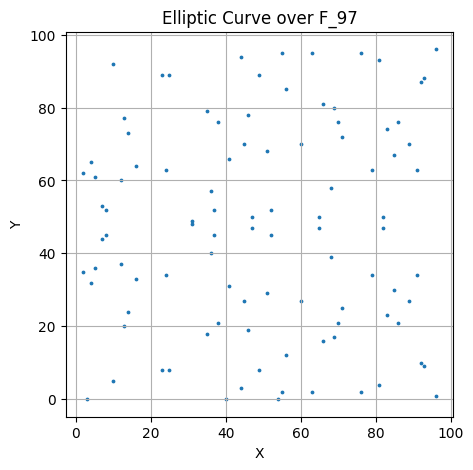

In [ ]:
p, a, b = 97, 17, 19
curve = Elliptic_Curve(p, a, b)
print("Is curve singular: ", curve.singular())
curve.get_points()

curve_get_points = curve.get_points()
while True:
    try:
        x, y = next(curve_get_points)
    except StopIteration:
        print('number of points (including infinity) = ', curve.n)
        break

curve.plot(figsize=(5,5), markersize=3)

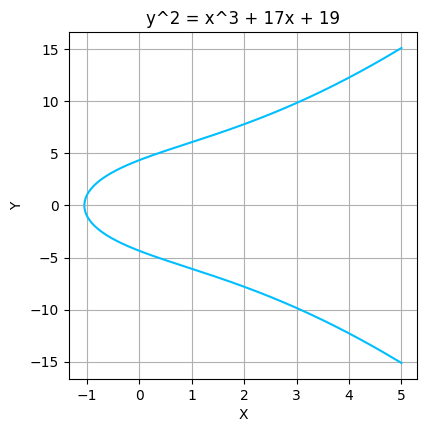

In [ ]:
def equation(x, a, b):
    return x**3 + a*x + b

xs = np.linspace(start=-1.049, stop=5, num=2000)
ys = np.sqrt(equation(xs, a, b))
plt.figure(figsize=(4.5,4.5))
plt.plot(xs, ys, color='deepskyblue')
plt.plot(xs, -ys, color='deepskyblue')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('y^2 = x^3 + 17x + 19')
plt.grid()
plt.show()

### SHA-256 From Scratch 🔐

I re-implemented the SHA-256 hashing algorithm without using Python’s `hashlib`.

- **Prime-based constants**: Generates the initial hash values `H` and round constants `K` from the fractional parts of √primes and ∛primes, as in the FIPS 180-4 spec.
- **Message preprocessing**: Converts input strings into padded 512-bit blocks, appending the message length.
- **Message schedule**: Builds the 64-word schedule `W` per block using σ₀/σ₁ operations.
- **Compression function**: Iteratively updates working variables `a…h` using `Ch`, `Maj`, and Σ operations, mixing in constants and the schedule.
- **Output**: Produces a 256-bit digest (hex string).  

For validation, results are compared against Python’s `hashlib.sha256`.

In [ ]:
def prime(n):
    yield 2
    yield 3
    p, count = 5, 2
    while count < n:
        is_prime = True
        for x in range(2,1+int(sqrt(p))):
            if (p/x) == int(p/x):
                is_prime = False
                break
        if is_prime == True:
            yield p
            count += 1
        p += 2

def frac_to_bin(x, max_digits):
    binary = ['0', 'b']
    for i in range(max_digits):
        x = (x - int(x))*2
        binary.append(str(int(x)))
    return int(''.join(binary), 2)

def get_Hs_and_Ks():
    H, K = [], []
    prime_gen_8, prime_gen_64 = prime(8), prime(64)
    while True:
        try:
            p = next(prime_gen_8)
            H.append(hex(frac_to_bin(sqrt(p), 32)))
        except StopIteration:
            break
    while True:
        try:
            p = next(prime_gen_64)
            K.append(hex(frac_to_bin(p**(1./3), 32)))
        except StopIteration:
            break
    Hs_and_Ks = namedtuple('Hs_and_Ks', ['H', 'K'])
    hs_and_ks = Hs_and_Ks(tuple(H), tuple(K))
    return hs_and_ks

def str_to_bin(input_msg):
    bin_list = [bin(ord(i))[2:].zfill(8) for i in input_msg]
    return ''.join(bin_list)

def sha256_preprocess(input_msg):
    binary = str_to_bin(input_msg)
    length_mod = len(binary) % (2**64)
    binary += '1'
    pad_num = (448 - (len(binary) % 512)) % 512
    binary += '0'*pad_num
    binary += bin(length_mod)[2:].zfill(64)
    if len(binary) % 512 == 0:
        return binary
    else:
        raise ValueError('Length is not a multiple of 512')

def ROTR(x, k, bits=32):
    return (x >> k) | (x << (bits-k)) & 0xFFFFFFFF

#def ROTL(x, k, bits=32):
    #return (x << k) | (x >> (bits-k)) & 0xFFFFFFFF

def sigma0_W(x):
    return ROTR(x,7) ^ ROTR(x,18) ^ (x>>3)

def sigma1_W(x):
    return ROTR(x,17) ^ ROTR(x,19) ^ (x>>10)

def get_W(block): # block is a 512-bit bhunk of the output of sha256_preprocess()
    '''gets the message schedule array for each 512-bit block'''
    W = np.zeros(64, dtype=np.uint32)
    for t in range(16):
        W[t] = int(block[t*32:(t+1)*32],2)
    for t in range(16,64):
        W[t] = sigma1_W(W[t-2]) + W[t-7] + sigma0_W(W[t-15]) + W[t-16] & 0xFFFFFFFF
    return W

def Ch(e, f, g):
    return (e & f) ^ ((~e) & g)

def Maj(a, b, c):
    return (a & b) ^ (a & c) ^ (b & c)

def sigma0_T(x):
    return ROTR(x,2) ^ ROTR(x,13) ^ ROTR(x,22)

def sigma1_T(x):
    return ROTR(x,6) ^ ROTR(x,11) ^ ROTR(x,25)

def get_T1(t, e, f, g, h, W, K):
    return (h + sigma1_T(e) + Ch(e,f,g) + K[t] + W[t]) % (2**32)

def get_T2(a, b, c):
    return (sigma0_T(a) + Maj(a,b,c)) % (2**32)

def compression(W, H, K): # W is the message schedule array for each 512-bit block
    a, b, c, d = int(H[0],16), int(H[1],16), int(H[2],16), int(H[3],16)
    e, f, g, h = int(H[4],16), int(H[5],16), int(H[6],16), int(H[7],16)

    K = tuple([int(k,16) for k in K])
    for t in range(64):
        T1, T2 = get_T1(t,e,f,g,h,W,K), get_T2(a,b,c)
        h = g
        g = f
        f = e
        e = (d + T1) % (2**32)
        d = c
        c = b
        b = a
        a = (T1 + T2) % (2**32)
    return f'{a:08x}{b:08x}{c:08x}{d:08x}{e:08x}{f:08x}{g:08x}{h:08x}'

def sha256(input_msg):
    H, K = get_Hs_and_Ks()
    input_preprocessed = sha256_preprocess(input_msg)

    for i in range(int(len(input_preprocessed)/512)):
        block = input_preprocessed[i*512:(i+1)*512]
        W = get_W(block)
        hash_hex = compression(W,H,K)
        yield hash_hex

In [ ]:
'''f = open('msg.txt', 'r')
msg = f.read()
f.close()'''

msg = 'abc'

hash_gen = sha256(msg)

for i, hash_hex in enumerate(hash_gen):
    print(f'block_{i} hashed = {hash_hex}')

block_0 hashed = 506e3058d39a216504d24d6cb85e2ce95ef50f24fb121210948d25b6961f4894


In [ ]:
hashed = hashlib.sha256(msg.encode('ascii')).hexdigest()
hashed

'ba7816bf8f01cfea414140de5dae2223b00361a396177a9cb410ff61f20015ad'